In [1]:
import numpy as np
import pandas as pd

In [6]:
import geopandas as gpd
gdf = gpd.read_file('data/gdf_with_clusters.shp')

In [7]:
gdf.head()

,Accident_D,Accident_T,At_Interse,CASE_Numbe,City,Day_of_Wee,Intersecti,Light_Cond,Location_o,Main_Stree,...,Work_Zon_2,Workers_Pr,Zone_ID,OBJECTID,latitude,longitude,latitude_r,longitude_,cluster,geometry
0,2020/01/03 19:35:00+00,1935,100 Feet From,2.020000e+09,VIRGINIA BEACH,FRI,NOT AT INTERSECTION,DARKNESS-ROAD LIGHTED,ON ROADWAY,1600 BLK GENERAL BOOTH BOULEVARD,...,None,None,na,1,36.785572,-75.998705,0.642029,-1.326428,0,POINT (-75.99871 36.78557)
1,2020/01/04 00:00:00+00,1505,Yes,2.020000e+09,VIRGINIA BEACH,SAT,NOT AT INTERSECTION,DAYLIGHT,ON ROADWAY,5670 INDIAN RIVER RD,...,None,None,na,2,36.805590,-76.190396,0.642379,-1.329773,1,POINT (-76.19040 36.80559)
2,2020/01/06 00:00:00+00,815,50 Feet From,2.020001e+09,VIRGINIA BEACH,MON,NOT AT INTERSECTION,DAYLIGHT,ON ROADWAY,700 GREAT NECK RD,...,None,None,na,3,36.852291,-76.048317,0.643194,-1.327294,2,POINT (-76.04832 36.85229)
3,2020/01/07 19:15:00+00,1915,150 Feet From,2.020001e+09,VIRGINIA BEACH,TUE,FOUR APPROACHES,DARKNESS-ROAD LIGHTED,ON ROADWAY,100 BLOCK LONDON BRIDGE,...,None,None,na,4,36.841992,-76.049118,0.643014,-1.327307,3,POINT (-76.04912 36.84199)
4,2020/01/06 19:35:00+00,1935,Yes,2.020001e+09,VIRGINIA BEACH,MON,FOUR APPROACHES,DARKNESS-ROAD LIGHTED,ON ROADWAY,LYNNHAVEN PKWY,...,None,None,na,5,36.795086,-76.117327,0.642195,-1.328498,4,POINT (-76.11733 36.79509)


In [10]:
# https://stackoverflow.com/questions/15222754/groupby-pandas-dataframe-and-select-most-common-value
info_from_cluster = gdf.groupby('cluster').agg(
    num_of_accidents=('cluster', 'size'),  # get the count
    avg_accident_time=('Accident_T', 'mean'),  # avg time
    most_common_day=('Day_of_Wee', lambda x: x.value_counts().index[0]), # most common day
)

info_from_cluster.head(10)

,num_of_accidents,avg_accident_time,most_common_day
cluster,,,
0,30,1563.200000,FRI
1,2,1559.500000,SAT
2,8,1458.375000,MON
3,29,1297.413793,THU
4,255,1444.949020,FRI
5,2,1390.500000,WED
6,366,1320.158470,FRI
7,2,1505.000000,THU
8,53,1495.245283,THU


In [36]:
from sklearn.preprocessing import OneHotEncoder
day_col = info_from_cluster[['most_common_day']]

ohe = OneHotEncoder(sparse_output=True, categories=[["SUN", "MON", "TUE", "WED", "THU", "FRI", "SAT"]])
day_col = ohe.fit_transform(day_col)

ohencoded = pd.DataFrame.sparse.from_spmatrix(day_col)
ohencoded.rename(columns={0: 'SUN', 1: 'MON', 2: 'TUE', 3: 'WED', 4: 'THU', 5: 'FRI', 6: 'SAT'}, inplace=True)
ohencoded.head()

,SUN,MON,TUE,WED,THU,FRI,SAT
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [40]:
cluster_info = pd.concat([info_from_cluster, ohencoded], axis=1)
cluster_info = cluster_info.drop(["most_common_day"], axis=1)
cluster_info.head()

,num_of_accidents,avg_accident_time,SUN,MON,TUE,WED,THU,FRI,SAT
0,30,1563.200000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,1559.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,8,1458.375000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,29,1297.413793,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,255,1444.949020,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_info)
cluster_scaled

C:\Users\andre\Documents\Python\ML4VA\env\Lib\site-packages\sklearn\utils\validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\andre\Documents\Python\ML4VA\env\Lib\site-packages\sklearn\utils\validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


array([[ 1.75732374,  0.4206046 , -0.37052057, ..., -0.40715875,
        -0.95235566, -0.45185545],
       [-0.13727786,  0.41351768, -0.37052057, ...,  2.45604445,
        -0.45065704, -1.45920291],
       [ 0.26870819,  0.21982451, -0.37052057, ..., -0.40715875,
         1.55613744,  1.56283948],
       ...,
       [-0.20494221,  0.75158291, -0.37052057, ..., -0.40715875,
         1.05443882,  1.05916575],
       [-0.20494221, -0.45510883,  2.6989055 , ..., -0.40715875,
         0.5527402 ,  0.55549202],
       [-0.20494221,  1.64606711, -0.37052057, ..., -0.40715875,
        -1.45405428,  0.05181829]])

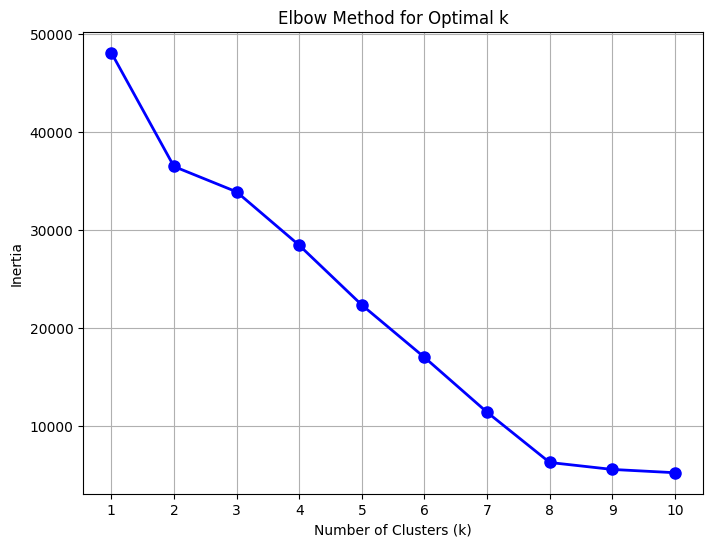

In [56]:
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt

inertia = []
possible_k_values = range(1, 11)  # You can adjust the range of k values as needed

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(cluster_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(possible_k_values, inertia, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(np.arange(1, 11, 1))  # Adjust the x-axis ticks based on your range of k values
plt.grid(True)
plt.show()

In [57]:
from sklearn.cluster import KMeans, AgglomerativeClustering
clusters = 8

# Perform KMeans clustering
kmeans = KMeans(n_clusters=clusters, n_init='auto', random_state=42)
kmeans_clusters = kmeans.fit_predict(cluster_scaled)
cluster_info['kmeans_cluster'] = kmeans_clusters

# Perform Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=clusters)
agglomerative_clusters = agglomerative.fit_predict(cluster_scaled)
cluster_info['agglomerative_cluster'] = agglomerative_clusters

In [59]:
cluster_of_clusters_info_kmeans = cluster_info.drop(["agglomerative_cluster"], axis=1).groupby('kmeans_cluster').agg('mean')
cluster_of_clusters_info_kmeans

,num_of_accidents,avg_accident_time,SUN,MON,TUE,WED,THU,FRI,SAT
kmeans_cluster,,,,,,,,,
0,3.662558,1380.520402,0.0,0.0,0.000000,1.0,0.000000,0.000000,0.000000
1,3.599671,1344.927728,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.000000
2,3.636896,1379.616470,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.000000
3,4.965517,1326.613502,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.000000
4,2.856452,1340.939648,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000
5,3.279110,1340.135843,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000
6,2.738636,1278.812618,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
7,284.000000,1396.100340,0.0,0.0,0.142857,0.0,0.142857,0.428571,0.285714


In [60]:
cluster_of_clusters_info_agglo = cluster_info.drop(["kmeans_cluster"], axis=1).groupby('agglomerative_cluster').agg('mean')
cluster_of_clusters_info_agglo

,num_of_accidents,avg_accident_time,SUN,MON,TUE,WED,THU,FRI,SAT
agglomerative_cluster,,,,,,,,,
0,5.806543,1327.383384,0.00569,0.0,0.001422,0.002845,0.990043,0.000000,0.000000
1,2.293893,1277.596235,1.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,2.856452,1340.939648,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000
3,3.279110,1340.135843,0.00000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,3.272025,1380.590523,0.00000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000
5,3.636896,1379.616470,0.00000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000
6,3.404290,1344.904155,0.00000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
7,284.000000,1396.100340,0.00000,0.0,0.142857,0.000000,0.142857,0.428571,0.285714


In [61]:
cluster_info.to_csv("cluster_of_clusters_info.csv")

In [2]:
cluster_info = pd.read_csv("cluster_of_clusters_info.csv")

In [3]:
cluster_info[cluster_info["kmeans_cluster"] == 7]

,Unnamed: 0,num_of_accidents,avg_accident_time,SUN,MON,TUE,WED,THU,FRI,SAT,kmeans_cluster,agglomerative_cluster
4,4,255,1444.949020,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7,7
6,6,366,1320.158470,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7,7
10,10,314,1460.248408,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7,7
62,62,174,1403.448276,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,7
92,92,453,1341.198675,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7,7
109,109,213,1370.530516,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,7
183,183,213,1432.169014,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7,7


In [4]:
import geopandas as gpd

In [5]:
gdf = gpd.read_file('gdf_with_clusters.shp')

In [16]:
gdf[gdf["cluster"] == 183].explore()